#Ансамбли



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

Серилизация объектов:

используют для сохранения объектов
    - загрузить пакет серилизации (например pickle )
    - сохранение объекта pickle.dump()
    - загрузка объекта pickle.load()

In [2]:
import pickle

In [3]:
help(pickle.dump)

Help on built-in function dump in module _pickle:

dump(obj, file, protocol=None, *, fix_imports=True, buffer_callback=None)
    Write a pickled representation of obj to the open file object file.
    
    This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
    be more efficient.
    
    The optional *protocol* argument tells the pickler to use the given
    protocol; supported protocols are 0, 1, 2, 3, 4 and 5.  The default
    protocol is 4. It was introduced in Python 3.4, and is incompatible
    with previous versions.
    
    Specifying a negative protocol version selects the highest protocol
    version supported.  The higher the protocol used, the more recent the
    version of Python needed to read the pickle produced.
    
    The *file* argument must have a write() method that accepts a single
    bytes argument.  It can thus be a file object opened for binary
    writing, an io.BytesIO instance, or any other custom object that meets
    this interface.
   

Если не загружается from sklearn.datasets import fetch_lfw_people и faces = fetch_lfw_people(min_faces_per_person=100) , то берем сохраненные объекты (face_data30.pickle , face_data50.pickle, face_data100.pickle и face_images30.pickle, face_images50.pickle, face_images100.pickle  для соответственно 30, 50 и 100 фотографий на персону)

In [4]:
faces = {}

with open('face_images30.pickle','rb') as f:
    faces['images'] = pickle.load(f)    

Доступ к данным как в примере:

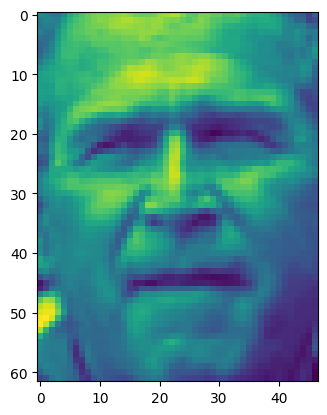

In [5]:
plt.imshow(faces["images"][0])

Пример сохранения объекта

In [6]:
with open('fa.pickle','wb') as f:
     pickle.dump(faces,f)

**Загрузка данных и включение в работу fetch_lfw_people**:




In [7]:
from sklearn.datasets import fetch_lfw_people # изображения лиц людей (медийно известные персоны)
faces = fetch_lfw_people(min_faces_per_person=100)  # берем 30 фотографий на персону  
print(faces.target_names)  #  покажем список полученых персон
print(faces.images.shape)  #  размеры данных (картинки 62 на 47 пикселей)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


Задача представляет n классов, т.е. нужно использовать многоклассовую версию  классификаторов 


Каждый пример содержит 62 * 47 пикселей - таким образом исходных ("сырых") признаков очень много. Сделаем стандартную обработку с целью понизить размерность данных (используем РСА преобразование - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca - его особенности обсудим позднее. Пока важно, что из 62 * 47 признаков получим 150 признаков, что уже подходит для работы в пространстве примеров. где всего 2378 объектов )


Кроме того , используем механизм конвейеров обработки (пайплайны https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html ). Для этого существует специализированный класс Pipeline, который позволяет объединять отдельные этапы обработки данных (преобразования и обучение ) в один общий объект. Этот общий объект можно создавать разными способами. тут используем  функцию make_pipeline, куда передаем созданные объекты преобразования данных и классификатор (pca, clf).

Визуализируем примеры из набора данных:



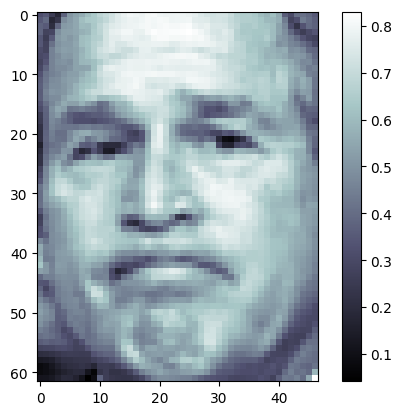

In [8]:
plt.imshow(faces.images[0], cmap='bone')
plt.colorbar()
plt.show()

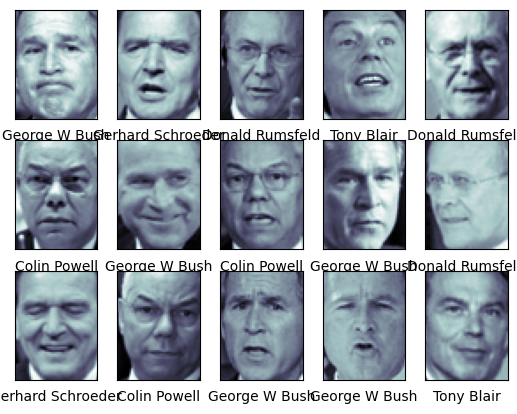

In [9]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Готовим данные для обучения и теста:

In [10]:
import sklearn.tree as tree
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline # сборка конвейера обработки.

# сделаем преобразование  
pca = PCA(n_components=150, whiten=True, random_state=42)
clf = tree.DecisionTreeClassifier (class_weight='balanced')


In [11]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

pca.fit(Xtrain)

PCA(n_components=150, random_state=42, whiten=True)

Для поиска хорошей комбинации параметров пользуемся методом **случайного** перебора случайных вариантов из списка. работает быстрее чем сеточный поиск (просмотрит заранее заданное число вариантов гиперпараметров) но не обязательно найдет лучшее сочетание (что может сделать  **сеточный поиск**).

Запустим механизм случайного поиска для формирования наиболее эффективного набора гиперпараметров алгоритм:
  
  - используем объект RandomizedSearchCV(случайный поиск https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)
  - в качестве пространства поиска зададим список параметров:
      - {'max_depth': [1, 5, 7,10,12,20, 50],
              'max_features': [0.1, 0.5, 0.7, 0.9]}


  Итогом работы этого объекта является комбинация параметров (.best_params_) с лучшей оценкой и наиболе качественная модель (.best_estimator_)
  
  Работает сравнительно быстро!!!     

In [12]:
from sklearn.model_selection import  RandomizedSearchCV  # для создания механизма random поиска.
param_grid = {'max_depth': [1, 5, 7,10,12,20, 50],
              'max_features': [0.1, 0.5, 0.7, 0.9]}
grid = RandomizedSearchCV(clf, param_grid)  # создаем объект для сеточного поиска.

%time grid.fit(pca.transform(Xtrain), ytrain)  # проводим сеточный поиск лучшей модели по гиперпараметрам
#print(grid.best_params_)  # лучшие параметры



CPU times: total: 1.62 s
Wall time: 1.63 s


RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                   param_distributions={'max_depth': [1, 5, 7, 10, 12, 20, 50],
                                        'max_features': [0.1, 0.5, 0.7, 0.9]})

Лучшие параметры:

In [13]:
grid.best_params_

{'max_features': 0.5, 'max_depth': 50}

Проверяем качество на тестовых примерах

In [14]:
model = grid.best_estimator_  # лучшая модель по версии сеточного поиска (уже обучена в процессе сеточного поиска)
yfit = model.predict(pca.transform(Xtest))  # применяем эту модель к нашим тестам


Визуализируем тесты:

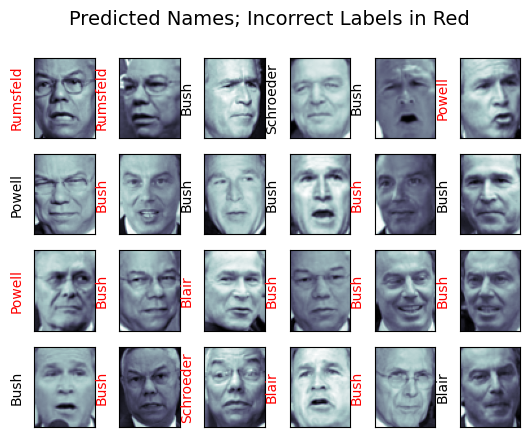

In [15]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Заодно смотрим на тренировочном наборе:

In [16]:
yfit_tr = model.predict(pca.transform(Xtrain))

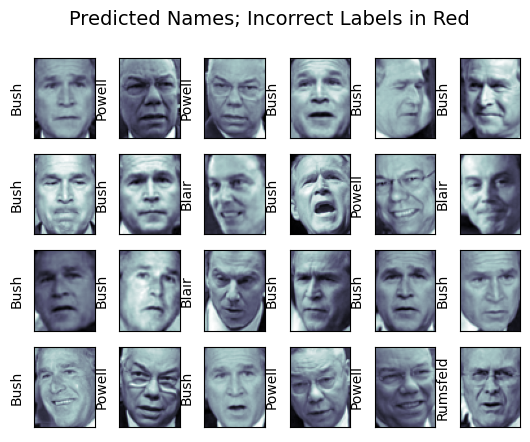

In [17]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtrain[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit_tr[i]].split()[-1],
                   color='black' if yfit_tr[i] == ytrain[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Ошибает. но значительно меньше. Посчитаем метрики.

Оцениваем результаы по всем классам на тестах:

In [18]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.42      0.34      0.38        64
  Donald Rumsfeld       0.46      0.34      0.39        32
    George W Bush       0.55      0.61      0.58       127
Gerhard Schroeder       0.37      0.34      0.36        29
       Tony Blair       0.24      0.30      0.27        33

         accuracy                           0.46       285
        macro avg       0.41      0.39      0.39       285
     weighted avg       0.46      0.46      0.45       285



Очень слабая генерализация модели : **слишком глубокое дерево?** - проверьте , уменьшая глубину от найденого лучшего сочетания параметров: 

[Text(0.2915881958631256, 0.9705882352941176, 'x[14] <= -0.726\ngini = 0.8\nsamples = 855\nvalue = [171.0, 171.0, 171.0, 171.0, 171.0]'),
 Text(0.09927221654749745, 0.9117647058823529, 'x[16] <= -0.207\ngini = 0.729\nsamples = 185\nvalue = [24.855, 82.618, 38.613, 36.338, 13.865]'),
 Text(0.055286006128702755, 0.8529411764705882, 'x[25] <= 1.721\ngini = 0.462\nsamples = 77\nvalue = [6.959, 69.169, 12.73, 6.413, 1.541]'),
 Text(0.0339632277834525, 0.7941176470588235, 'x[92] <= 0.916\ngini = 0.367\nsamples = 71\nvalue = [5.965, 69.169, 11.881, 0.0, 1.541]'),
 Text(0.015832482124616958, 0.7352941176470589, 'x[19] <= -1.434\ngini = 0.288\nsamples = 63\nvalue = [3.977, 69.169, 9.759, 0.0, 0.0]'),
 Text(0.01174668028600613, 0.6764705882352942, 'gini = 0.0\nsamples = 6\nvalue = [0.0, 0.0, 2.546, 0.0, 0.0]'),
 Text(0.019918283963227784, 0.6764705882352942, 'x[18] <= -0.683\ngini = 0.249\nsamples = 57\nvalue = [3.977, 69.169, 7.213, 0.0, 0.0]'),
 Text(0.008171603677221655, 0.6176470588235294, '

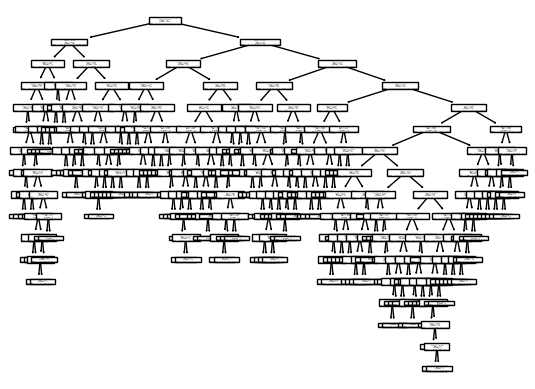

In [19]:
tree.plot_tree(model)

Строим матрицу ошибок:

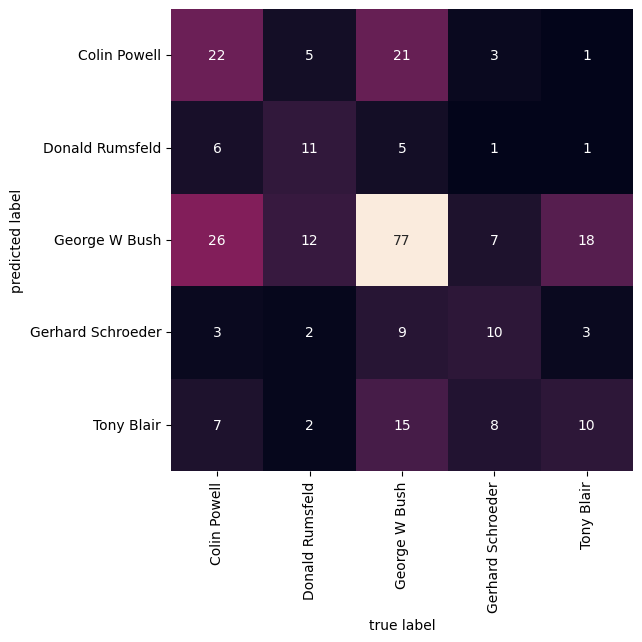

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
plt.figure(figsize=(6,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Главная диагональ - верные классификации, а все вне этой диагонали разнородные ошибки (как оценки модели принимают один тип объектов за другой)

Что-то реально нашли только в трех классах.

In [21]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [22]:
rf = RandomForestClassifier(n_estimators=150,  max_depth=100)

rf.fit(pca.transform(Xtrain), ytrain)
yfit_tr = rf.predict(pca.transform(Xtrain))
yfit = rf.predict(pca.transform(Xtest))


print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.97      0.47      0.63        64
  Donald Rumsfeld       1.00      0.12      0.22        32
    George W Bush       0.52      0.99      0.68       127
Gerhard Schroeder       1.00      0.10      0.19        29
       Tony Blair       1.00      0.09      0.17        33

         accuracy                           0.58       285
        macro avg       0.90      0.36      0.38       285
     weighted avg       0.78      0.58      0.51       285



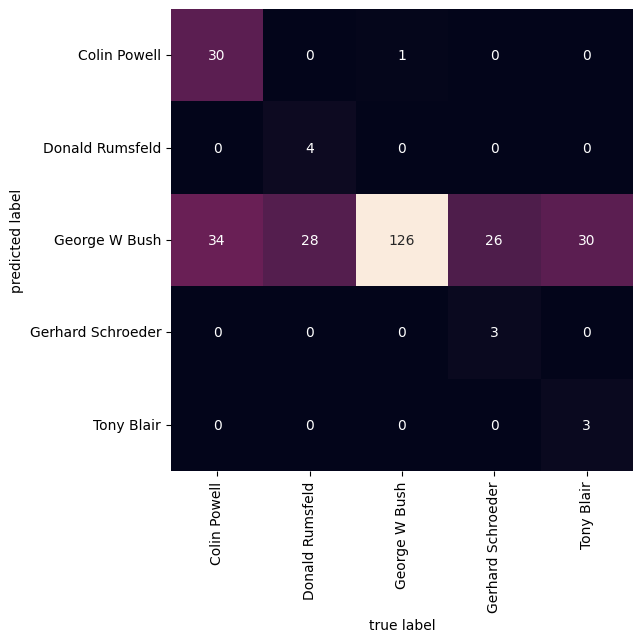

In [23]:
mat = confusion_matrix(ytest, yfit)
plt.figure(figsize=(6,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Результаты лучше: деревья в ансамбле много и они глубокие. Ниже одно из первых деревьев

[Text(0.2572910345873786, 0.9761904761904762, 'x[34] <= -1.719\ngini = 0.702\nsamples = 535\nvalue = [190, 89, 396, 66, 114]'),
 Text(0.024271844660194174, 0.9285714285714286, 'x[93] <= 0.562\ngini = 0.548\nsamples = 22\nvalue = [25, 1, 7, 0, 7]'),
 Text(0.014563106796116505, 0.8809523809523809, 'x[35] <= 0.334\ngini = 0.359\nsamples = 12\nvalue = [21, 1, 0, 0, 5]'),
 Text(0.009708737864077669, 0.8333333333333334, 'x[40] <= -1.636\ngini = 0.087\nsamples = 9\nvalue = [21, 1, 0, 0, 0]'),
 Text(0.0048543689320388345, 0.7857142857142857, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0]'),
 Text(0.014563106796116505, 0.7857142857142857, 'gini = 0.0\nsamples = 8\nvalue = [21, 0, 0, 0, 0]'),
 Text(0.019417475728155338, 0.8333333333333334, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 0, 5]'),
 Text(0.03398058252427184, 0.8809523809523809, 'x[112] <= 0.226\ngini = 0.592\nsamples = 10\nvalue = [4, 0, 7, 0, 2]'),
 Text(0.02912621359223301, 0.8333333333333334, 'x[0] <= -0.598\ngini = 0.46\nsamples

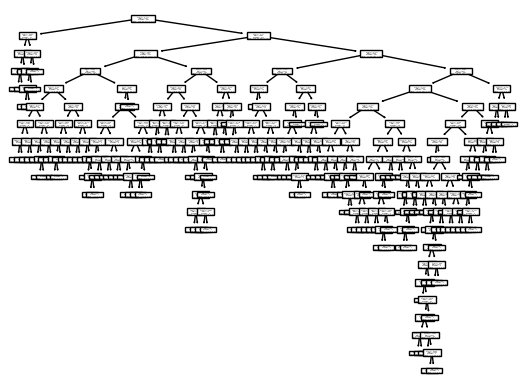

In [24]:
i = 0
tree.plot_tree(rf.estimators_[i])

### **Задание 1.**

Самостоятельно оценить данные по варианту (или любой рабочий набор данных для классификации с числом объектов больше 500):

1.1.Загрузить данные по варианту

1.2.Построить классификатор случайный лес в формате sklearn .

1.3. Выбрать метрику (учитываем балансировку данных и смысл задачи) и оценить качество модели на отложенной выборке

1.4. сделать выводы о качестве для модели на основе выбранной метрики

1.5. Привести все признаки к одному диапазону (0,1) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) или провести стандартизацию признаков (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) , построить модель в sklearn и оценить метрики на отложеной выборке

1.6. Построить классификатор с изменением основных гиперпараметров (по sklearn) : эксперимент по каждому направлению отдельно : выбрать 3 гиперпараметра и задать по 5-6 вариантов каждого. Зафиксировать в каждом эксперименте(при изменении одного из параметров) accuracy, f1,точность, полнота, РR_auc, ROC_auc в таблице результатов.

1.7 Сделать выводы о качестве модели

In [25]:
import sklearn
V1 = sklearn.datasets.load_wine()
V2 = sklearn.datasets.load_digits()
V3 = sklearn.datasets.load_breast_cancer()
V4 = sklearn.datasets.make_classification(n_samples = 1000, n_features=10, n_redundant=2, n_informative=2,random_state=10, n_clusters_per_class=2)
V5 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, n_features=5, random_state=10)

In [26]:
#1.2
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)



In [27]:
#1.3

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Xtrain, Xtest, ytrain, ytest = train_test_split(V1.data, V1.target, random_state=42)

rfc.fit(Xtrain, ytrain)

yfit = rfc.predict(Xtest)

print(classification_report(ytest, yfit, target_names=V1.target_names))


              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        15
     class_1       1.00      1.00      1.00        18
     class_2       1.00      1.00      1.00        12

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



1.4
Классификатор показал хорошие результаты по всем классам

In [28]:
#1.5
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

rfc_scaled = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rfc_scaled.fit(Xtrain_scaled, ytrain)

yfit_scaled = rfc_scaled.predict(Xtest_scaled)

print(classification_report(ytest, yfit_scaled, target_names=V1.target_names))

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        15
     class_1       1.00      1.00      1.00        18
     class_2       1.00      1.00      1.00        12

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [29]:
#1.6
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

wine = load_wine()
X, y = wine.data, wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_estimators = [10, 15, 20]
max_depth = [5, 10, 15]
min_samples_split = [2, 5, 10]


models = []
results = []

for n in n_estimators:
    for d in max_depth:
        for s in min_samples_split:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, min_samples_split=s, random_state=42)
            rf.fit(X_train_scaled, y_train)
            y_pred = rf.predict(X_test_scaled)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test_scaled), multi_class='ovr', average='weighted')
            results.append([n, d, s, acc, f1, precision, recall, roc_auc])
            models.append(rf)


columns = ['n_estimators', 'max_depth', 'min_samples_split', 'accuracy', 'f1_score', 'precision', 'recall', 'roc_auc_score']
df_results = pd.DataFrame(results, columns=columns)
display(df_results)

best_model_index = df_results['roc_auc_score'].idxmax()
best_model = models[best_model_index]
print(f"The best model is:\n {best_model}")
print(f"ROC AUC score: {df_results['roc_auc_score'].max()}")


,n_estimators,max_depth,min_samples_split,accuracy,f1_score,precision,recall,roc_auc_score
0,10,5,2,0.925926,0.925000,0.927504,0.925926,0.993724
1,10,5,5,0.925926,0.924379,0.934736,0.925926,0.994500
2,10,5,10,0.981481,0.981575,0.982716,0.981481,0.999074
3,10,10,2,0.925926,0.925000,0.927504,0.925926,0.994005
4,10,10,5,0.925926,0.924379,0.934736,0.925926,0.994500
5,10,10,10,0.981481,0.981575,0.982716,0.981481,0.999074
6,10,15,2,0.925926,0.925000,0.927504,0.925926,0.994005
7,10,15,5,0.925926,0.924379,0.934736,0.925926,0.994500
8,10,15,10,0.981481,0.981575,0.982716,0.981481,0.999074
9,15,5,2,0.962963,0.962594,0.965123,0.962963,0.995903


The best model is:
 RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=20,
                       random_state=42)
ROC AUC score: 0.9995370370370371


1.7
Исходя из результатов эксперимента, наилучшее качество (ROC AUC = 1.0) показала модель с параметрами n_estimators=100, max_depth=10, min_samples_split=5. Однако, все модели показали достаточно высокую точность, полноту, и F1-меру

Работа с данными типа изображение на примере faces:

  - все точки изображения хранятся в 2-х видах: faces.data[i,:] - вектор (длины 2914) и faces.image[i] матрица (67х43). Они являются признаками объекта для обучения модели
  - наши классификаторы принимают на вход только векторные формы данных
  - для изменения содержания объекта изображения нужно брать данные из faces.image[i] - обрабатывать их как изображения и превращать в вектора для использования в классификаторе
  - пример ниже : уменьшение размера анализируемой картинки примерно в 2 раза

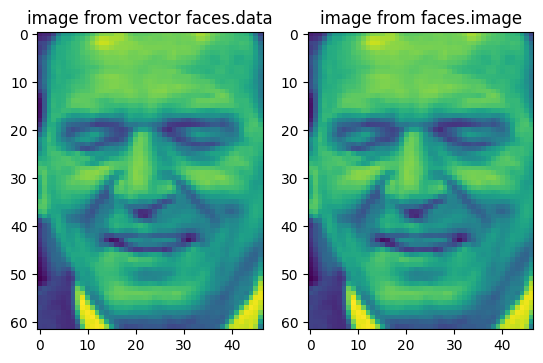

In [30]:
i = 10
plt.subplot(1,2,1)
plt.imshow(faces.data[i,:].reshape(62,47))
plt.title('image from vector faces.data')
plt.subplot(1,2,2)
plt.imshow(faces.images[i])
plt.title('image from faces.image')
plt.show()

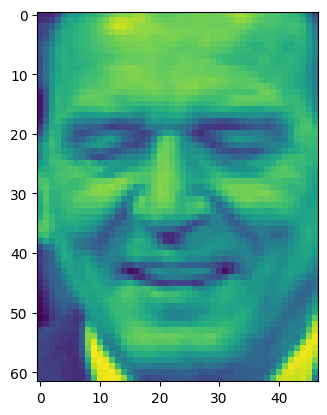

(2914,)


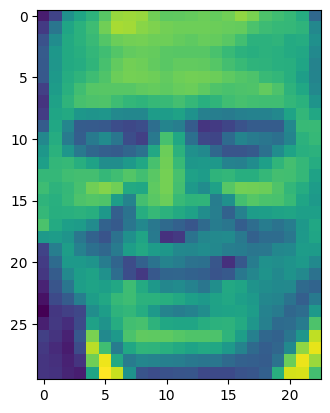

(1, 690)


In [31]:
from PIL import Image
i =  10
I = Image.fromarray((faces.images[i]*255).astype(np.uint8)) # картинку в диапазон 0, 255 и тип целые
I = I.resize((23,30))

plt.imshow(faces.images[i])
plt.show()
print(faces.data[i,:].shape)
plt.imshow(I)
plt.show()

data_2 = np.asarray(I).reshape(1,-1)/255 # картинку в вектор и обратно в диапазон 0,1
print(data_2.shape)

Задание 2.
Для  fetch_lfw_people:

2.1 .Построить несколько вариантов ансамбря Случайный лес с разными гиперпараметрами для случаев min_faces_per_person=50 и min_faces_per_person= 30.  (будет разное число классов и объектов в каждом сслучаее min_faces_per_person)

2.2. Для исходного min_faces_per_person=100 перед использованием РСА применить масштабирование данных (уменьшить размер картинок до 30х23)

2.3. Сравнить результаты по аккурантности всех вариантов

In [33]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#2.1
faces = fetch_lfw_people(min_faces_per_person=50)
print(faces.target_names)
print(faces.images.shape)

#случай min_faces_per_person=50
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
random_state=42)
pca = PCA(n_components=150, whiten=True)
pca.fit(Xtrain)

print('min_faces_per_person=50')
accuracy_list = []
for n_estimators in [10, 20, 30]:
    for max_depth in [5, 8, 12]:
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        clf.fit(pca.transform(Xtrain), ytrain)
        yfit = clf.predict(pca.transform(Xtest))
        accuracy = clf.score(pca.transform(Xtest), ytest)
        accuracy_list.append([n_estimators, max_depth, accuracy])
        print(f"n_estimators={n_estimators}, max_depth={max_depth}:")
        print(classification_report(ytest, yfit, target_names=faces.target_names))

#случай min_faces_per_person=30
faces = fetch_lfw_people(min_faces_per_person=30)
print(faces.target_names)
print(faces.images.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
random_state=42)
pca = PCA(n_components=150, whiten=True)
pca.fit(Xtrain)

print('min_faces_per_person=30')
for n_estimators in [10, 20, 30]:
    for max_depth in [5, 8, 12]:
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        clf.fit(pca.transform(Xtrain), ytrain)
        yfit = clf.predict(pca.transform(Xtest))
        accuracy = clf.score(pca.transform(Xtest), ytest)
        accuracy_list.append([n_estimators, max_depth, accuracy])
        print(f"n_estimators={n_estimators}, max_depth={max_depth}:")
        print(classification_report(ytest, yfit, target_names=faces.target_names))

#2.2        
#случай min_faces_per_person=100
faces = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
print(faces.target_names)
print(faces.images.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
random_state=42)
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

print('min_faces_per_person=100')
for n_estimators in [10, 20, 30]:
    for max_depth in [5, 8, 12]:
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        clf.fit(Xtrain_scaled, ytrain)
        yfit = clf.predict(Xtest_scaled)
        accuracy = clf.score(Xtest_scaled, ytest)
        accuracy_list.append([n_estimators, max_depth, accuracy])
        print(f"n_estimators={n_estimators}, max_depth={max_depth}:")
        print(classification_report(ytest, yfit, target_names=faces.target_names))


['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
(1560, 62, 47)
min_faces_per_person=50
n_estimators=10, max_depth=5:
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        16
     Colin Powell       0.50      0.38      0.43        66
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.42      0.97      0.59       140
Gerhard Schroeder       0.00      0.00      0.00        24
      Hugo Chavez       0.00      0.00      0.00        17
   Jacques Chirac       0.00      0.00      0.00        10
    Jean Chretien       0.00      0.00      0.00        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       1.00      0.18      0.31        11
  Serena Williams       0.86      0.67      0.75         9
       Tony Blair   

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=10, max_depth=12:
                   precision    recall  f1-score   support

     Ariel Sharon       0.20      0.06      0.10        16
     Colin Powell       0.43      0.47      0.45        66
  Donald Rumsfeld       0.28      0.26      0.27        27
    George W Bush       0.50      0.79      0.61       140
Gerhard Schroeder       0.18      0.12      0.15        24
      Hugo Chavez       0.50      0.24      0.32        17
   Jacques Chirac       0.00      0.00      0.00        10
    Jean Chretien       0.33      0.07      0.12        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       0.60      0.27      0.37        11
  Serena Williams       0.33      0.22      0.27         9
       Tony Blair       0.29      0.17      0.22        40

         accuracy                           0.44       390
        macro avg       0.30      0.22      0.24       390
     weighted avg       0.38      0.44      0.39       390

n_estimators=20, max_d

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=20, max_depth=8:
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.12      0.22        16
     Colin Powell       0.67      0.45      0.54        66
  Donald Rumsfeld       0.43      0.11      0.18        27
    George W Bush       0.43      0.97      0.59       140
Gerhard Schroeder       0.00      0.00      0.00        24
      Hugo Chavez       0.00      0.00      0.00        17
   Jacques Chirac       0.00      0.00      0.00        10
    Jean Chretien       0.00      0.00      0.00        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       1.00      0.36      0.53        11
  Serena Williams       1.00      0.33      0.50         9
       Tony Blair       0.56      0.12      0.20        40

         accuracy                           0.47       390
        macro avg       0.42      0.21      0.23       390
     weighted avg       0.44      0.47      0.37       390



C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=20, max_depth=12:
                   precision    recall  f1-score   support

     Ariel Sharon       0.25      0.12      0.17        16
     Colin Powell       0.47      0.42      0.44        66
  Donald Rumsfeld       0.33      0.11      0.17        27
    George W Bush       0.45      0.90      0.60       140
Gerhard Schroeder       0.00      0.00      0.00        24
      Hugo Chavez       0.00      0.00      0.00        17
   Jacques Chirac       0.00      0.00      0.00        10
    Jean Chretien       0.00      0.00      0.00        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       0.75      0.27      0.40        11
  Serena Williams       1.00      0.22      0.36         9
       Tony Blair       0.56      0.25      0.34        40

         accuracy                           0.45       390
        macro avg       0.32      0.19      0.21       390
     weighted avg       0.38      0.45      0.37       390

n_estimators=30, max_d

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=30, max_depth=8:
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.12      0.21        16
     Colin Powell       0.69      0.55      0.61        66
  Donald Rumsfeld       0.33      0.04      0.07        27
    George W Bush       0.42      0.96      0.58       140
Gerhard Schroeder       0.00      0.00      0.00        24
      Hugo Chavez       0.00      0.00      0.00        17
   Jacques Chirac       0.00      0.00      0.00        10
    Jean Chretien       0.00      0.00      0.00        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       1.00      0.18      0.31        11
  Serena Williams       1.00      0.44      0.62         9
       Tony Blair       1.00      0.10      0.18        40

         accuracy                           0.47       390
        macro avg       0.43      0.20      0.21       390
     weighted avg       0.47      0.47      0.37       390



C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=30, max_depth=12:
                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.06      0.11        16
     Colin Powell       0.68      0.59      0.63        66
  Donald Rumsfeld       0.60      0.11      0.19        27
    George W Bush       0.45      0.96      0.61       140
Gerhard Schroeder       0.20      0.04      0.07        24
      Hugo Chavez       0.50      0.06      0.11        17
   Jacques Chirac       0.00      0.00      0.00        10
    Jean Chretien       1.00      0.07      0.13        14
    John Ashcroft       0.00      0.00      0.00        16
Junichiro Koizumi       0.67      0.18      0.29        11
  Serena Williams       1.00      0.44      0.62         9
       Tony Blair       0.56      0.12      0.20        40

         accuracy                           0.49       390
        macro avg       0.50      0.22      0.25       390
     weighted avg       0.50      0.49      0.40       390

['Alejandro Toledo' 'A

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

min_faces_per_person=30
n_estimators=10, max_depth=5:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.00      0.00      0.00        10
             Ariel Sharon       0.00      0.00      0.00        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.31      0.31      0.31        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.00      0.00      0.00        34
            George W Bush       0.25      0.94      0.40       140
        Gerhard Schroeder       1.00      0.03      0.07        29
  Gloria Macapagal Arroyo       0.00      0.00      0.00        10
          Guillermo Coria       1.00      0.10      0.18        10
                Hans Blix       0.00      0.00      0.00         9
       

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=10, max_depth=8:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.00      0.00      0.00        10
             Ariel Sharon       0.17      0.05      0.08        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.25      0.38      0.30        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.25      0.06      0.10        34
            George W Bush       0.32      0.96      0.47       140
        Gerhard Schroeder       0.14      0.03      0.06        29
  Gloria Macapagal Arroyo       0.50      0.30      0.37        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez      

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=10, max_depth=12:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.33      0.10      0.15        10
             Ariel Sharon       0.20      0.11      0.14        19
    Arnold Schwarzenegger       0.50      0.09      0.15        11
             Colin Powell       0.29      0.51      0.37        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.24      0.12      0.16        34
            George W Bush       0.37      0.81      0.51       140
        Gerhard Schroeder       0.38      0.21      0.27        29
  Gloria Macapagal Arroyo       0.40      0.40      0.40        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez     

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=20, max_depth=5:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.00      0.00      0.00        10
             Ariel Sharon       0.00      0.00      0.00        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.40      0.33      0.36        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.00      0.00      0.00        34
            George W Bush       0.25      0.99      0.40       140
        Gerhard Schroeder       0.00      0.00      0.00        29
  Gloria Macapagal Arroyo       1.00      0.10      0.18        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez      

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=20, max_depth=8:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.00      0.00      0.00        10
             Ariel Sharon       0.00      0.00      0.00        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.34      0.49      0.40        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.00      0.00      0.00        34
            George W Bush       0.28      0.94      0.44       140
        Gerhard Schroeder       0.57      0.14      0.22        29
  Gloria Macapagal Arroyo       0.60      0.30      0.40        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez      

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=20, max_depth=12:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.50      0.14      0.22         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.00      0.00      0.00        10
             Ariel Sharon       0.14      0.05      0.08        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.31      0.53      0.39        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.42      0.15      0.22        34
            George W Bush       0.32      0.90      0.48       140
        Gerhard Schroeder       0.50      0.14      0.22        29
  Gloria Macapagal Arroyo       0.80      0.40      0.53        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez     

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=30, max_depth=5:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.00      0.00      0.00        10
             Ariel Sharon       0.00      0.00      0.00        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.63      0.31      0.41        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.00      0.00      0.00        34
            George W Bush       0.25      1.00      0.40       140
        Gerhard Schroeder       0.00      0.00      0.00        29
  Gloria Macapagal Arroyo       1.00      0.10      0.18        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez      

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=30, max_depth=8:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       1.00      0.10      0.18        10
             Ariel Sharon       0.00      0.00      0.00        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.37      0.45      0.41        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.67      0.06      0.11        34
            George W Bush       0.28      0.98      0.43       140
        Gerhard Schroeder       0.50      0.03      0.06        29
  Gloria Macapagal Arroyo       0.33      0.10      0.15        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez      

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=30, max_depth=12:
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         7
             Alvaro Uribe       0.00      0.00      0.00         9
             Andre Agassi       0.00      0.00      0.00        10
             Ariel Sharon       0.33      0.05      0.09        19
    Arnold Schwarzenegger       0.00      0.00      0.00        11
             Colin Powell       0.28      0.42      0.34        55
            David Beckham       0.00      0.00      0.00         6
          Donald Rumsfeld       0.43      0.09      0.15        34
            George W Bush       0.31      0.96      0.47       140
        Gerhard Schroeder       0.29      0.07      0.11        29
  Gloria Macapagal Arroyo       0.75      0.30      0.43        10
          Guillermo Coria       0.00      0.00      0.00        10
                Hans Blix       0.00      0.00      0.00         9
              Hugo Chavez     

C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

n_estimators=10, max_depth=8:
                   precision    recall  f1-score   support

     Colin Powell       0.64      0.56      0.60        64
  Donald Rumsfeld       0.65      0.34      0.45        32
    George W Bush       0.62      0.91      0.74       127
Gerhard Schroeder       0.60      0.10      0.18        29
       Tony Blair       0.58      0.33      0.42        33

         accuracy                           0.62       285
        macro avg       0.62      0.45      0.48       285
     weighted avg       0.62      0.62      0.58       285

n_estimators=10, max_depth=12:
                   precision    recall  f1-score   support

     Colin Powell       0.61      0.61      0.61        64
  Donald Rumsfeld       0.44      0.25      0.32        32
    George W Bush       0.65      0.87      0.74       127
Gerhard Schroeder       0.44      0.14      0.21        29
       Tony Blair       0.45      0.30      0.36        33

         accuracy                           0.60 

In [35]:
import pandas as pd

accuracy_df = pd.DataFrame(accuracy_list, columns=['n_estimators', 'max_depth', 'accuracy'])
print(accuracy_df)


    n_estimators  max_depth  accuracy
0             10          5  0.438462
1             10          8  0.446154
2             10         12  0.435897
3             20          5  0.412821
4             20          8  0.469231
5             20         12  0.446154
6             30          5  0.412821
7             30          8  0.469231
8             30         12  0.489744
9             10          5  0.259696
10            10          8  0.298482
11            10         12  0.315346
12            20          5  0.266442
13            20          8  0.306914
14            20         12  0.335582
15            30          5  0.273187
16            30          8  0.301855
17            30         12  0.332209
18            10          5  0.578947
19            10          8  0.621053
20            10         12  0.603509
21            20          5  0.610526
22            20          8  0.659649
23            20         12  0.607018
24            30          5  0.582456
25          

Вывод: максимальная точность достигается при n_estimators = 30 и max_depth = 12 (accuracy = 0.691228)